# Spotify Playlist Analysis


<span class = "myhighlight">Objective.</span> Using Python, the project goal is to implement a k-means clustering algorithm, a technique often used in machine learning, and use it for data analysis. We write various functions making use of lists, sets, dictionaries, sorting, and graph data structures for computational problem solving and analysis.


In [42]:
import csv
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
from operator import index

First, we create a Client Credentials Flow Manager used in server-to-server authentication by passing the necessary parameters to the [Spotify OAuth](https://github.com/spotipy-dev/spotipy/blob/master/spotipy/oauth2.py#L261) class. We provide a client id and client secret to the constructor of this authorization flow, which does not require user interaction.
    

In [43]:
# Set client id and client secret
client_id = '4cf3afdca2d74dc48af9999b1b7c9c61'
client_secret = 'f6ca08ad37bb41a0afab5ca1dc74b208'

# Spotify authentication token
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)

Now, we want to get the full details of the tracks of a playlist based on a playlist ID, URI, or URL. The following function takes a playlist and gets information from each individual song.


In [44]:
# Get playlist song features and artist info
def playlist_features(id, artist_id, playlist_id):
    
    # Create Spotify API client variables
    meta = sp.track(id)
    audio_features = sp.audio_features(id)
    artist_info = sp.artist(artist_id)
    playlist_info = sp.playlist(playlist_id)

    # Metadata
    name = meta['name']
    track_id = meta['id']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    artist_id = meta['album']['artists'][0]['id']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']

    # Main artist name, popularity, genre
    artist_pop = artist_info["popularity"]
    artist_genres = artist_info["genres"]

    # Track features
    acousticness = audio_features[0]['acousticness']
    danceability = audio_features[0]['danceability']
    energy = audio_features[0]['energy']
    instrumentalness = audio_features[0]['instrumentalness']
    liveness = audio_features[0]['liveness']
    loudness = audio_features[0]['loudness']
    speechiness = audio_features[0]['speechiness']
    tempo = audio_features[0]['tempo']
    valence = audio_features[0]['valence']
    key = audio_features[0]['key']
    mode = audio_features[0]['mode']
    time_signature = audio_features[0]['time_signature']
    
    # Basic playlist info
    playlist_name = playlist_info['name']

    return [name, track_id, album, artist, artist_id, release_date, length, popularity, 
            artist_pop, artist_genres, acousticness, danceability, 
            energy, instrumentalness, liveness, loudness, speechiness, 
            tempo, valence, key, mode, time_signature, playlist_name]

Choose a specific playlist to analyze by copying the URL from the Spotify Player interface. Using that link, the following code uses the playlist_tracks method to retrieve a list of IDs and corresponding artists for each track from the playlist. 



In [45]:
def get_playlist_tracks(playlist_URI):
    tracks = []
    results = sp.playlist_tracks(playlist_URI)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])     
    return tracks

In [46]:
# Spotify playlist url
playlist_links = ["https://open.spotify.com/playlist/1nvpVNmzL7Vi1pXcQEiaLx?si=6842f41a58284be3"]

playlist_ids = []
track_ids = []
artist_uris = []

for link in playlist_links:
    playlist_URI = link.split("/")[-1].split("?")[0]
    
    # Extract song ids and artists from playlist
    for i in get_playlist_tracks(playlist_URI):
        track_ids.append(i['track']["id"])
        artist_uris.append(i['track']["artists"][0]["uri"])
        playlist_ids.append(playlist_URI)
  

In [47]:
len(playlist_ids)

106

--------------------

The following code loops through each track ID in the playlist and extracts additional song information by calling the function we created above. From there, we can create a pandas data frame by passing in the extracted information and giving the column header names we want. 

In [48]:
# Loop over track ids
all_tracks = [playlist_features(track_ids[i], artist_uris[i], playlist_ids[i])
              for i in range(len(track_ids))]

In [49]:
# Create dataframe
df = pd.DataFrame(
    all_tracks, columns=['name', 'track_id', 'album', 'artist', 'artist_id','release_date',
                     'length', 'popularity', 'artist_pop', 'artist_genres',
                     'acousticness', 'danceability', 'energy',
                     'instrumentalness', 'liveness', 'loudness',
                     'speechiness', 'tempo', 'valence', 'key', 'mode',
                     'time_signature', 'playlist'])
# Save to csv file
df.to_csv("data/my_playlist.csv", sep=',')

--------------------------------------------------------


#### Spotify Playlists Data Extraction

In [50]:
spotify_playlists = pd.read_csv('data/spotify_playlists.csv', encoding_errors='ignore', index_col=0, header=0)
spotify_playlists['playlist'].value_counts()

New Music Friday      100
New Pop Picks         100
just hits             100
Hip Hop Controller     99
RapCaviar              51
Today's Top Hits       50
Hot Hits USA           50
Name: playlist, dtype: int64

------------------------------------------------------

### The Data


How many songs do we have?

In [51]:
# Number of rows and columns
rows, cols = df.shape
print(f'Number of songs: {rows}')
print(f'Number of attributes per song: {cols}')

Number of songs: 106
Number of attributes per song: 23


In [52]:
# Get a song string search
def getMusicName(elem):
    return f"{elem['artist']} - {elem['name']}"

# Select song and get track info
anySong = df.loc[15]
anySongName = getMusicName(anySong)
print('name:', anySongName)

name: ODIE - In My Head


-----------------------

## Spotify Songs - Similarity Search




Below, we create a query to retrieve similar elements based on Euclidean distance. In mathematics, the Euclidean distance between two points is the length of the line segment between the two points. In this sense, the closer the distance is to 0, the more similar the songs are.



#### [KNN Algorithm](https://www.kaggle.com/code/leomauro/spotify-songs-similarity-search/notebook)


The k-Nearest Neighbors (KNN) algorithm searches for k similar elements based on a query point at the center within a predefined radius. 



In [53]:
def knnQuery(queryPoint, arrCharactPoints, k):
    queryVals = queryPoint.tolist()
    distVals = []
    
    # Copy of dataframe indices and data
    tmp = arrCharactPoints.copy(deep = True)  
    for index, row in tmp.iterrows():
        feat = row.values.tolist()
        
        # Calculate sum of squared differences
        ssd = sum(abs(feat[i] - queryVals[i]) ** 2 for i in range(len(queryVals)))
        
        # Get euclidean distance
        distVals.append(ssd ** 0.5)
        
    tmp['distance'] = distVals
    tmp = tmp.sort_values('distance')
    
    # K closest and furthest points
    return tmp.head(k).index, tmp.tail(k).index

In [54]:
# Execute KNN removing the query point
def querySimilars(df, columns, idx, func, param):
    arr = df[columns].copy(deep = True)
    queryPoint = arr.loc[idx]
    arr = arr.drop([idx])
    return func(queryPoint, arr, param)

**KNN Query Example.** 

Our function allows us to create personalized query points and modify the columns to explore other options. For example, the following code selects a specific set of song attributes and then searches for the $k$ highest values of these attributes set equal to one.

Let's search for  $k=3$  similar songs to a query point $\textrm{songIndex} = 6$. 

In [55]:
from sklearn import preprocessing 
scaler=preprocessing.MinMaxScaler() #instantiate a scaler
#all the feature values are in the range [0,1] ,except of loudnes
#so let's scale it to fit the exact same range
loudness2 = df["loudness"].values
loudness_scaled=scaler.fit_transform(loudness2.reshape(-1, 1))
df['loudness_scaled'] = loudness_scaled

In [56]:
# Select song and column attributes
songIndex = 4 # query point
columns = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'liveness', 
           #'loudness_scaled', 'tempo', 
           'speechiness', 'valence']

# Set query parameters
func, param = knnQuery,3

# Implement query
response = querySimilars(df, columns, songIndex, func, param)

print("---- Query Point ----")
print(getMusicName(df.loc[songIndex]))
print('---- k = 3 similar songs ----')
for track_id in response[0]:
    track_name = getMusicName(df.loc[track_id])
    print(track_name)
print('---- k = 3 nonsimilar songs ----')
for track_id in response[1]:
    track_name = getMusicName(df.loc[track_id])
    print(track_name)

---- Query Point ----
AG Club - Memphis
---- k = 3 similar songs ----
Roddy Ricch - Stop Breathing
The Game - Eazy
Lil Yachty - Yacht Club (feat. Juice WRLD)
---- k = 3 nonsimilar songs ----
Post Malone - Internet
ODIE - In My Head
Frank Ocean - In My Room


The code below implements the same idea as above, but queries each track in a given playlist instead of a single defined query point.

In [57]:
similar_count = {} # Similar songs count
nonsimilar_count = {} # Non-similar songs count

for track_index in df.index:
    response = querySimilars(df, columns, track_index, func, param)
    
    # Get similar songs
    for similar_index in response[0]:
        track = getMusicName(df.loc[similar_index])
        if track in similar_count:
            similar_count[track] += 1
        else:
            similar_count[track] = 1
    
    # Get non-similar songs
    for nonsimilar_index in response[1]:
        track = getMusicName(df.loc[nonsimilar_index])
        if track in nonsimilar_count:
            nonsimilar_count[track] += 1
        else:
            nonsimilar_count[track] = 1

NON SIMILAR SONG COUNT:

In [60]:
nonsimilar = dict(sorted(nonsimilar_count.items(), key=lambda item: item[1], reverse=True))

print('---- NON SIMILAR SONG COUNTS ----')
for track_name, track_count in nonsimilar.items():
    if track_count >= 8:
        print(track_name, ':', track_count)

---- NON SIMILAR SONG COUNTS ----
Frank Ocean - In My Room : 83
ODIE - In My Head : 46
Post Malone - Internet : 42
Blxst - Hurt : 25
Lil Uzi Vert - The Way Life Goes (feat. Nicki Minaj & Oh Wonder) - Remix : 19
Kanye West - Waves : 12
Tyla Yaweh - Understand Me : 11
Mark Battles - Lemme Talk : 9
Kanye West - Violent Crimes : 9
SAINt JHN - The Best Part of Life : 8


SIMILAR SONG COUNT:

In [61]:
similar = dict(sorted(similar_count.items(), key=lambda item: item[1], reverse=True))

print('---- SIMILAR SONG COUNTS ----')
for track_name, track_count in similar.items():
    if track_count >= 5:
        print(track_name, ':', track_count)

---- SIMILAR SONG COUNTS ----
YoungBoy Never Broke Again - Home Ain't Home (feat. Rod Wave) : 9
Kodak Black - MoshPit (feat. Juice WRLD) : 8
Lil Xan - Lies (feat. Lil Skies) : 8
Tyla Yaweh - High Right Now (feat. Wiz Khalifa) - Remix : 7
iann dior - I might : 7
mike. - commas : 7
Juice WRLD - Life's A Mess (feat. Halsey) : 6
Fresco Trey - Key To My Heart : 6
Azizi Gibson - Rain : 6
Mac Miller - Weekend (feat. Miguel) : 5
Polo G - RAPSTAR : 5
Rae Sremmurd - Denial : 5
Juice WRLD - Stay High : 5
Lil Uzi Vert - The Way Life Goes (feat. Nicki Minaj & Oh Wonder) - Remix : 5
Sheff G - Weight On Me : 5
whiterosemoxie - west side boys : 5
Post Malone - Waiting For Never : 5
Post Malone - Big Lie : 5
Juice WRLD - In My Head : 5
Justin Stone - Goldmine : 5
Juice WRLD - Rich And Blind : 5
Baby Keem - 16 : 5
KILJ - No Remedy : 5


---------------------------------------------------------------


### Similar Artists Web Visual


First, we want to find the most frequently occurring artist in a given playlist. We use the value_counts function to get a sequence containing counts of unique values sorted in descending order. 


In [62]:
# pandas count distinct values in column
tallyArtists = df.value_counts(["artist", "artist_id"]).reset_index(name='counts')
topArtist = tallyArtists['artist_id'][1]
tallyArtists.head(4)

,artist,artist_id,counts
0,Juice WRLD,4MCBfE4596Uoi2O4DtmEMz,10
1,Post Malone,246dkjvS1zLTtiykXe5h60,8
2,SAINt JHN,0H39MdGGX6dbnnQPt6NQkZ,3
3,Lil Uzi Vert,4O15NlyKLIASxsJ0PrXPfz,3


#### Links Dataset

I can retrieve artist and artist-related data using the following code, passing the artist ID to the artist and artist-related artist functions under the spotipy package. The returned list of similar artists is sorted by similarity score based on the listener data.

In [63]:
# create links table
a = sp.artist(topArtist)
ra = sp.artist_related_artists(topArtist)

# dictionary of lists 
links_dict = {"source_name":[],"source_id":[],"target_name":[],"target_id":[]};
for artist in ra['artists']:
    links_dict["source_name"].append(a['name'])
    links_dict["source_id"].append(a['id'])
    links_dict["target_name"].append(artist['name'])
    links_dict["target_id"].append(artist['id'])

Let’s take it a step further and query the API for similar artists for those similar to the most frequent artist in the given playlist. In other words, we generate two generations of the most similar artists.

In [65]:
for i in range(0, 4):
    a = sp.artist(links_dict['target_id'][i])
    ra = sp.artist_related_artists(links_dict['target_id'][i])
    time.sleep(.5)
    for artist in ra['artists']:
        links_dict["source_name"].append(a['name'])
        links_dict["source_id"].append(a['id'])
        links_dict["target_name"].append(artist['name'])
        links_dict["target_id"].append(artist['id'])

# Convert links dict to dataframe
links = pd.DataFrame(links_dict) 

# Export to excel sheet             
links.to_excel("data/links.xlsx", index = False)

In [66]:
links.head(3)

,source_name,source_id,target_name,target_id
0,Post Malone,246dkjvS1zLTtiykXe5h60,Rae Sremmurd,7iZtZyCzp3LItcw1wtPI3D
1,Post Malone,246dkjvS1zLTtiykXe5h60,Huncho Jack,6extd4B6hl8VTmnlhpl2bY
2,Post Malone,246dkjvS1zLTtiykXe5h60,Tyla Yaweh,1MXZ0hsGic96dWRDKwAwdr


#### Points Dataset

In [67]:
# create "points" table             
all_artist_ids = list(set(links_dict['source_id'] + links_dict['target_id']))


In [68]:
name_count = {}
all_artist_names = list(links_dict['source_name'] + links_dict['target_name'])
for name in all_artist_names:
    if name in name_count:
        name_count[name] += 1
        
    else:
        name_count[name] = 1

In [69]:
# dictionary of lists 
points_dict = {"id":[],"name":[],"connections":[],"followers":[],"popularity":[],"url":[],"image":[]};

for id in all_artist_ids:
    time.sleep(.5)
    a = sp.artist(id)
    points_dict['id'].append(id)
    points_dict['name'].append(a['name'])
    points_dict['connections'].append(name_count[a['name']])
    points_dict['followers'].append(a['followers']['total'])
    points_dict['popularity'].append(a['popularity'])
    points_dict['url'].append(a['external_urls']['spotify'])
    points_dict['image'].append(a['images'][0]['url'])

# Convert links dict to dataframe
points = pd.DataFrame(points_dict) 

# Export to excel sheet             
points.to_excel("data/points.xlsx", index = False)

In [70]:
points.head(3)

,id,name,connections,followers,popularity,url,image
0,0VRj0yCOv2FXJNP47XQnx5,Quavo,3,6179310,82,https://open.spotify.com/artist/0VRj0yCOv2FXJN...,https://i.scdn.co/image/ab6761610000e5eb1454de...
1,7iZtZyCzp3LItcw1wtPI3D,Rae Sremmurd,45,7008543,73,https://open.spotify.com/artist/7iZtZyCzp3LItc...,https://i.scdn.co/image/ab6761610000e5eb209b54...
2,34Y0ldeyUv7jBvukWOGASO,Bobby Shmurda,2,1390475,60,https://open.spotify.com/artist/34Y0ldeyUv7jBv...,https://i.scdn.co/image/ab6761610000e5ebee12e6...


#### Flourish Network Graph

The following visualization is based on the [Spotify Similiar Artists API](https://unboxed-analytics.com/data-technology/visualizing-rap-communities-wtih-python-spotifys-api/) article and created with flourish studio.


In [162]:
%%html

<iframe src='https://flo.uri.sh/visualisation/12232729/embed' title='Interactive or visual content' class='flourish-embed-iframe' frameborder='0' scrolling='no' style='width:100%;height:600px;' sandbox='allow-same-origin allow-forms allow-scripts allow-downloads allow-popups allow-popups-to-escape-sandbox allow-top-navigation-by-user-activation'></iframe><div style='width:100%!;margin-top:4px!important;text-align:right!important;'><a class='flourish-credit' href='https://public.flourish.studio/visualisation/12232729/?utm_source=embed&utm_campaign=visualisation/12232729' target='_top' style='text-decoration:none!important'><img alt='Made with Flourish' src='https://public.flourish.studio/resources/made_with_flourish.svg' style='width:105px!important;height:16px!important;border:none!important;margin:0!important;'> </a></div>

---------------------------------------------

## Organized Songs in a Playlist

In [158]:
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import cluster, decomposition

In [400]:
songs = pd.read_csv('data/my_playlist.csv', encoding_errors='ignore', index_col=0, header=0)
songs = df[['name','acousticness', 'danceability', 'energy', 'instrumentalness', 
            'liveness', 'speechiness', 'tempo', 'valence',  'loudness_scaled']]
songs.describe()

,acousticness,danceability,energy,instrumentalness,liveness,speechiness,tempo,valence,loudness_scaled
count,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000,106.000000
mean,0.255301,0.679500,0.586915,0.006967,0.158788,0.148254,119.174302,0.398518,0.667653
std,0.223641,0.115911,0.122452,0.064370,0.085350,0.120728,33.817415,0.208096,0.198418
min,0.001200,0.375000,0.214000,0.000000,0.059800,0.029500,74.013000,0.035700,0.000000
25%,0.067600,0.620750,0.502750,0.000000,0.103250,0.056225,83.601750,0.247500,0.562824
50%,0.194500,0.700500,0.598500,0.000000,0.125000,0.091950,120.108500,0.373000,0.699416
75%,0.406000,0.760500,0.670250,0.000002,0.182750,0.217250,150.784500,0.554500,0.803714
max,0.877000,0.935000,0.881000,0.661000,0.419000,0.525000,178.046000,0.835000,1.000000


In [401]:
labels = songs.values[:,0]
X = songs.values[:,1:10]

AffinityPropagation(affinity='euclidean', convergence_iter=15, copy=True,
                    damping=0.5, max_iter=200, preference=-200,
                    random_state=None, verbose=False)

In [ ]:
kmeans = cluster.AffinityPropagation(preference=-200)
kmeans.fit(X)

In [402]:
predictions = {}
for p,n in zip(kmeans.predict(X),labels):
    if not predictions.get(p):
        predictions[p] = []
        
    predictions[p] += [n]

for p in predictions:
    print("Category",p)
    print("-----")
    for n in predictions[p]:
        print(n)
    print("")

Category 2
-----
2 AM
Rain
Savior
Break from Toronto
Weekend (feat. Miguel)
Lemme Talk
The Plan (feat. Juicy J)
Sandman
Weight On Me

Category 0
-----
Golden Child
Blastoff (feat. Juice Wrld & Trippie Redd)
Waiting For Never
Rich & Sad
Hide (feat. Seezyn)
FEEL SOMETHING (feat. Marshmello)
I might
Wishing Well
Go Again
Everyday

Category 1
-----
Eazy
Sober (feat. Roddy Ricch & Post Malone)
I Pray For You (feat. Labrinth & MALICE)
In My Head
WAIT FOR U (feat. Drake & Tems)
For The Squadron
Empty
Home Ain't Home (feat. Rod Wave)
Don't Forget Me
Go Flex
I Cannot Be (A Sadder Song) (with Gunna)
Fast
The Way Life Goes (feat. Oh Wonder)
Noticed
Thousand Miles
RAPSTAR
Cutlass (ft. ScHoolboy Q)
Doom
Already Dead
Nikes On
life got crazy
west side boys
HOLY TRINITY (feat. Rich The Kid)
Tommy Lee (feat. Post Malone)
The Way Life Goes (feat. Nicki Minaj & Oh Wonder) - Remix

Category 6
-----
MoshPit (feat. Juice WRLD)
Yacht Club (feat. Juice WRLD)
Paranoid
In My Room
In My Head
be cautious
Crew Lov

------------------------------

### K Means Clustering


Using K Means clustering, I will be choosing to [break my playlist into 3 smaller playlists](https://github.com/ankushbharadwaj/reorganize-my-spotify-playlist/blob/master/reorder%20my%20spotify%20playlist.ipynb).



In [397]:
from sklearn.cluster import KMeans
import seaborn as sns
%matplotlib inline
playlist_tracks = df[['artist','name','acousticness','danceability','energy',
                      'liveness', 'instrumentalness','speechiness','valence']]

kmeans = KMeans(n_clusters = 3)
kmeans.fit(playlist_tracks.drop(['artist', 'name'], axis = 1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, random_state=None, tol=0.0001, verbose=0)

<AxesSubplot:ylabel='count'>

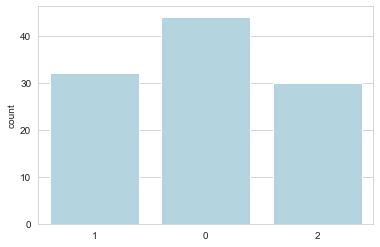

In [398]:
sns.countplot([str(group) for group in kmeans.labels_], color = 'lightblue')

#### Visualizing the Clusters


Moving forward, let's look at differences in the audio features of each group.



In [399]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(playlist_tracks.drop(['artist', 'name'], axis = 1))
scaled_data = scaler.transform(playlist_tracks.drop(['artist', 'name'], axis = 1))

Text(0, 0.5, 'PC2: 0.194')

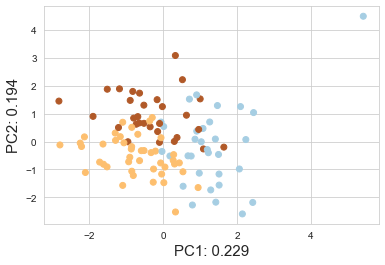

In [385]:
from sklearn.decomposition import PCA
pca = PCA(n_components =2)
pca.fit(scaled_data)
data_pca = pca.transform(scaled_data)

plt.scatter(data_pca[:,0], data_pca[:,1], c = list(kmeans.labels_), cmap = 'Paired')
plt.xlabel('PC1: {:.3f}'.format(pca.explained_variance_ratio_[0]), size = 15)
plt.ylabel('PC2: {:.3f}'.format(pca.explained_variance_ratio_[1]), size = 15)

In [386]:
playlist_tracks['group'] = list(kmeans.labels_)
playlist_tracks = playlist_tracks.astype({'group': str})

In [387]:
means = pd.DataFrame(index = range(0,3), 
                    columns = list(playlist_tracks[playlist_tracks['group'] == '0'].describe().loc['mean'].index))
means.iloc[0] = playlist_tracks[playlist_tracks['group'] == '0'].describe().loc['mean']
means.iloc[1] = playlist_tracks[playlist_tracks['group'] == '1'].describe().loc['mean']
means.iloc[2] = playlist_tracks[playlist_tracks['group'] == '2'].describe().loc['mean']
means

,acousticness,danceability,energy,liveness,instrumentalness,speechiness,valence
0,0.539687,0.737625,0.537219,0.151313,0.022516,0.158881,0.457741
1,0.141199,0.640227,0.581545,0.165268,0.000242,0.136611,0.230323
2,0.119303,0.6751,0.6478,0.157257,0.000247,0.153993,0.582033


In [388]:
playlist_tracks = playlist_tracks.sort_values(by = ['group'])
playlist_tracks.head()

,artist,name,acousticness,danceability,energy,liveness,instrumentalness,speechiness,valence,group
0,SwaVay,2 AM,0.434,0.783,0.341,0.362,0.000098,0.0727,0.184,0
32,Mac Miller,Weekend (feat. Miguel),0.470,0.843,0.435,0.147,0.000000,0.1780,0.190,0
35,Migos,Antisocial (feat. Juice WRLD),0.784,0.667,0.390,0.121,0.000000,0.0491,0.528,0
36,Post Malone,Internet,0.841,0.469,0.489,0.103,0.000000,0.0314,0.201,0
45,YoungBoy Never Broke Again,Home Ain't Home (feat. Rod Wave),0.424,0.773,0.602,0.125,0.000000,0.1730,0.553,0
